In [1]:
import numpy as np
from skimage import io, data, transform
from scipy import sparse, signal
from scipy import io as spio
import matplotlib.pyplot as plt
from img_utils import cgls, get_lxly
plt.gray()
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Tikhonov regularization
Tikhonov regularization is one of the simplest methods to enforce smoothness on an image. This method can be used in many cases: it can be used to denoise images, but it can also be used to reconstruct images when they do not have full information. The more complicated scenario, which I will be evaluating, is as follows: We have some original image $I$. Then, we apply a convolution to it (in this case, a Gaussian blur), and select a subset of the pixels of the result. Finally, we add some Gaussian noise. 

After this process, we have a vector $b$, and we want to find some $x$ that maximizes $\Pr(x\mid b)\propto \Pr(b\mid x) \Pr(x)$. Because the additive noise is gaussian, our forward model is of the form $b = Ax + E$, with $E\sim \mathcal{N}(0, \sigma_x^2)$, and $A$ is the composition of the convolution and subsampling matrices. We will let $L_x$ and $L_y$ be the discrete derivative matrices in the $x$ and $y$ directions respectively (assuming symmetric boundaries). 

From this, Tikhonov regularization assigns a prior on the data $x$ by assuming that the derivative of $x$ is approximately normally distributed with variance $\sigma_l^2$. This translates into a prior of the form $$\Pr(x) \propto \exp\left(-\frac{1}{2\sigma_l^2}\left\lVert L_x x \right\rVert^2\right)\exp\left(-\frac{1}{2\sigma_l^2}\left\lVert L_y x \right\rVert^2\right)=\exp\left(-\frac{1}{2\sigma_l^2}\left(\left\lVert L_x x \right\rVert^2+\left\lVert L_y x \right\rVert^2\right)\right)$$

Because we assume additive Gaussian error in the forward model, we can then say 
$$
    \Pr(b\mid x) \propto \exp\left(-\frac{1}{2\sigma_x^2}\left\lVert Ax-b \right\rVert^2\right)
$$
This results in a posterior density of
$$
    \Pr(b\mid x) \propto \exp\left(-\frac{1}{2\sigma_x^2}\left\lVert Ax-b \right\rVert^2-\frac{1}{2\sigma_l^2}\left(\left\lVert L_x x \right\rVert^2+\left\lVert L_y x \right\rVert^2\right)\right)
$$
If we then take the negative log likelihood, we get
$$
    -\log L(x) = \frac{1}{2\sigma_x^2}\left\lVert Ax-b \right\rVert^2 +\frac{1}{2\sigma_l^2}\left(\left\lVert L_x x \right\rVert^2+\left\lVert L_y x \right\rVert^2\right)
$$
This can easily be optimized by a least squares solve on system
$$
\begin{pmatrix}
\frac{1}{2\sigma_x^2} A\\
\frac{1}{2\sigma_l^2} L_x\\
\frac{1}{2\sigma_l^2} L_y
\end{pmatrix} x
=
\begin{pmatrix}
\frac{1}{2\sigma_x^2} b\\
0\\
0
\end{pmatrix}
$$
I use a Conjugate Gradient for Least Squares solver because it is appropriate to use on large sparse systems.

One thing to note here is that if we assume circular boundary conditions, everything can be greatly sped up, because the convolution matrix would then be diagonalizable under the DFT, allowing the least squares solve to be computed in a single step.

In [2]:
im = transform.resize(data.camera(),(256,256))

/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


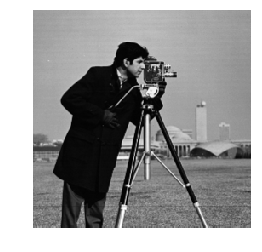

In [3]:
plt.imshow(im)
plt.axis('off');

In [4]:
n = np.prod(im.shape)
sn = im.shape[0]

In [5]:
Lx, Ly = get_lxly(n)

In [12]:
sigma = 0.05
np.random.seed(1234)
indices = np.random.choice(n, size=(int(0.1*n)), replace=False)
ap = A = spio.loadmat('./convmat.mat')['A']
a = A = A.tocsr()[indices, :]
np.random.seed(4514142)
b = A @ im.reshape(-1) + np.random.randn(A.shape[0]) * sigma
m, n = A.shape

In [10]:
fmat = sparse.vstack((A * 3, Lx, Ly))
y = np.concatenate((b * 3, np.zeros(Lx.shape[0]), np.zeros(Ly.shape[0])))
t = cgls(fmat, y, niter=500).reshape(*im.shape)

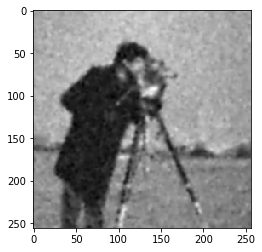

In [11]:
plt.imshow(t)